In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# I. Loading the dataset "development.csv"
df = pd.read_csv('development.csv')
print(df.head())

# II. Preprocessing 
# 1. Checking for Missing Values
missing_values = df.isnull().sum().sum()
if missing_values > 0:
    print("\nMissing values are found to be:", missing_values)
else:
    print("\nNo missing values are found.")

# 2. Examining Nature of the values
if all(df.dtypes[1:] == float):
    print("\nAll columns contain numeric float values, suitable for processing.")
else:
    print("\nSome columns do not contain numeric values. Further processing required.")

# 3. Cross Validation by Pandas
print("\nDataframe Shape:", df.shape)
print(df.tail())

# 4. Statistical Analysis of the Features with target Coordinates
feature_names = ['pmax', 'negpmax', 'tmax', 'area', 'rms']
target_names = ['x', 'y']

stats_summary = pd.DataFrame()

for feature in feature_names:
    feature_columns = [col for col in df.columns if col.startswith(feature)]
    mean = df[feature_columns].mean()
    median = df[feature_columns].median()
    std_dev = df[feature_columns].std()
    variance = df[feature_columns].var()
    correlations = {f'Correlation_{target}': df[feature_columns + [target]].corr()[target].drop(target) for target in target_names}
    combined_summary = pd.DataFrame({
        'mean': mean,
        'median': median,
        'std_dev': std_dev,
        'variance': variance
    })

    for target, corr_values in correlations.items():
        combined_summary[target] = corr_values
    
    stats_summary = pd.concat([stats_summary, combined_summary])
    plt.figure(figsize=(10, 6))
    df[feature_columns].hist(bins=30, alpha=0.5, layout=(3, 6), figsize=(12, 8))
    plt.suptitle(f'Histograms for {feature}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.savefig(f'{feature}_histograms.png')
    plt.close()
    
stats_summary.to_csv('complete_statistical_summary.csv')

print("\nThe complete statistical summary has been saved to 'complete_statistical_summary.csv'")
print("\nHistograms for each feature group have been saved to the current directory.")

# 5. Clean and remove the discovered Noisy Columns (0, 7, 12, 15, 16, 17)
features = ['pmax', 'negpmax', 'tmax', 'area', 'rms']
noisy_columns = [0, 7, 12, 15, 16, 17]

for feature in features:
    for col in noisy_columns:
        col_name = f'{feature}[{col}]'
        if col_name in df.columns:
            df.drop(col_name, axis=1, inplace=True)

df_clean = df.copy() 

# 6. Feature engineering: Finalized Combinations include squares of individual features + squares of feature combos (product of features)
for i in range(18):
    if i not in noisy_columns:
        df_clean.loc[:, f'squared_pmax_{i}'] = df_clean[f'pmax[{i}]'] ** 2
        df_clean.loc[:, f'squared_negpmax_{i}'] = df_clean[f'negpmax[{i}]'] ** 2
        df_clean.loc[:, f'squared_tmax_{i}'] = df_clean[f'tmax[{i}]'] ** 2
        df_clean.loc[:, f'squared_area_{i}'] = df_clean[f'area[{i}]'] ** 2
        df_clean[f'pmax_negpmax_squared_{i}'] = (df_clean[f'pmax[{i}]'] * df_clean[f'negpmax[{i}]']) ** 2
        df_clean[f'pmax_tmax_squared_{i}'] = (df_clean[f'pmax[{i}]'] * df_clean[f'tmax[{i}]']) ** 2
        df_clean[f'negpmax_tmax_squared_{i}'] = (df_clean[f'negpmax[{i}]'] * df_clean[f'tmax[{i}]']) ** 2

print(df_clean.head()) # Confirm the number of columns in the new file
df_clean.to_csv('without_noise_data.csv', index=False)


       x      y   pmax[0]  negpmax[0]   area[0]     tmax[0]    rms[0]  \
0  200.0  200.0  4.066907  -17.690173  2.847932    0.600000  2.007042   
1  200.0  200.0  5.916801   -4.717111  5.792778   79.765174  1.564535   
2  200.0  200.0  4.286652   -5.316132  2.356390   74.600000  1.404622   
3  200.0  200.0  4.003635   -4.617459  2.189005   43.000000  1.512162   
4  200.0  200.0  4.448146   -4.848743  3.997002  196.667482  1.101113   

    pmax[1]  negpmax[1]   area[1]  ...    pmax[16]  negpmax[16]    area[16]  \
0  5.409161  -17.721210  4.538778  ...  607.109118   -36.282996  583.899899   
1  4.414289   -4.736827  3.720435  ...  630.348007   -39.715988  580.042799   
2  4.567191   -5.985437  3.490490  ...  613.880342   -40.679678  580.407491   
3  5.019058   -4.229949  6.786200  ...  600.714957   -43.206601  579.882635   
4  3.250262   -5.783587  2.449456  ...  609.723785   -43.570892  590.156125   

    tmax[16]   rms[16]    pmax[17]  negpmax[17]    area[17]   tmax[17]  \
0  72.373094

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [2]:
# III. Model Training

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error 
import numpy as np
import time


target_columns = ['x', 'y']
X = df_clean.drop(target_columns, axis=1)
y = df_clean[target_columns]

# Manually input hyperparameters: Best selected parameters 
n_estimators = 700 # No. of trees
max_features = 'sqrt' # Selection of features
max_depth = 50 # Depth of the trees
min_samples_split = 2  # Features to split at internal node
min_samples_leaf = 1  # Features to be at leaf node
max_leaf_nodes = None   # Grow trees with maximum nodes

# Initializing the Random Forest Algorithm
base_regressor = RandomForestRegressor(
    n_estimators=n_estimators,
    max_features=max_features,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_leaf_nodes=max_leaf_nodes,
    random_state=42, # Used no.42 as the seed for this model
    n_jobs=-1 # Used all cores to process this model; script can also be used without this
)

start_time = time.time()

model = MultiOutputRegressor(base_regressor)
model.fit(X, y)

# Extra step to examine the performance of the model on the entire development set
training_prediction = model.predict(X)
r2 = r2_score(y, training_prediction)
mse = mean_squared_error(y, training_prediction)

end_time = time.time()
duration_seconds = end_time - start_time
duration_minutes = duration_seconds / 60

print(f"R-squared score of this model on the development set: {r2}")
print(f"Mean Squared Error value of this model on the development set: {mse}")
print(f"\nModel training took {duration_minutes:.2f} minutes.")

R-squared score of this model on the development set: 0.9998739046514664
Mean Squared Error value of this model on the development set: 1.7080441156462585

Model training took 59.13 minutes.


In [3]:
# IV. Model Evaluation

import pandas as pd

# Loading the evaluation set separately
evaluation_set = pd.read_csv('evaluation.csv')

# Same earlier steps (performed on the development set) to be repeated on the evaluation set
features = ['pmax', 'negpmax', 'tmax', 'area', 'rms']
noisy_columns = [0, 7, 12, 15, 16, 17]

for feature in features:
    for col in noisy_columns:
        col_name = f'{feature}[{col}]'
        if col_name in evaluation_set.columns:
            evaluation_set.drop(col_name, axis=1, inplace=True)

# Same earlier steps (performed on the development set) to be repeated on the evaluation set
for i in range(18):
    if i not in noisy_columns:
        evaluation_set.loc[:, f'squared_pmax_{i}'] = evaluation_set[f'pmax[{i}]'] ** 2
        evaluation_set.loc[:, f'squared_negpmax_{i}'] = evaluation_set[f'negpmax[{i}]'] ** 2
        evaluation_set.loc[:, f'squared_tmax_{i}'] = evaluation_set[f'tmax[{i}]'] ** 2
        evaluation_set.loc[:, f'squared_area_{i}'] = evaluation_set[f'area[{i}]'] ** 2
        evaluation_set[f'pmax_negpmax_squared_{i}'] = (evaluation_set[f'pmax[{i}]'] * evaluation_set[f'negpmax[{i}]']) ** 2
        evaluation_set[f'pmax_tmax_squared_{i}'] = (evaluation_set[f'pmax[{i}]'] * evaluation_set[f'tmax[{i}]']) ** 2
        evaluation_set[f'negpmax_tmax_squared_{i}'] = (evaluation_set[f'negpmax[{i}]'] * evaluation_set[f'tmax[{i}]']) ** 2

evaluation = evaluation_set.drop('Id', axis=1)
evaluation_predictions = model.predict(evaluation)

# Formatting of the submission file
submission_file = ['{:.1f}|{:.1f}'.format(pred[0], pred[1]) for pred in evaluation_predictions]
submission_df = pd.DataFrame({
    'Id': evaluation_set['Id'], 
    'Predicted': submission_file
})

submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"Final Submission by the trained model is saved to the'{submission_filename}'")


Final Submission by the trained model is saved to the'submission.csv'


In [ ]:
# Highly exhaustive and computationally intensive Techniques
# Script used in early training of the Model using optimized hyperparameters Tuning Algorithms

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd

target_columns = ['x', 'y']
X = df_clean.drop(target_columns, axis=1)
y = df_clean[target_columns]

# Hyperparameters space to be defined for the tuning algorithm GridSeacrCV
param_grid = {
    'estimator__n_estimators': [400, 600, 800], 
    'estimator__max_features': ['sqrt'],  
    'estimator__max_depth': [10, 30, 50] 
}

base_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)
multi_output_regressor = MultiOutputRegressor(base_regressor)

# GridSearchCV algorithm used for finding the best Hyperparameters
grid_search = GridSearchCV(
    estimator=multi_output_regressor,
    param_grid=param_grid,
    cv=3,  
    verbose=2,  
    n_jobs=-1 
)

grid_search.fit(X, y)
optimized_model = grid_search.best_estimator_

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# OR
# Hyperparameters space to be defined for the tuning algorithm RandomizedSeacrCV
random_search = RandomizedSearchCV(
    model, 
    param_distributions, 
    n_iter=100,  
    cv=3, 
    scoring='neg_mean_squared_error', 
    verbose=3, 
    random_state=42,
    error_score='raise'
)

random_search.fit(X, y)
optimized_model_2 = random_search.best_estimator_
optimzed_model_2.fit(X, y)

print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}") # By default R^2 scored value


All feature importances have been saved to feature_importances.csv


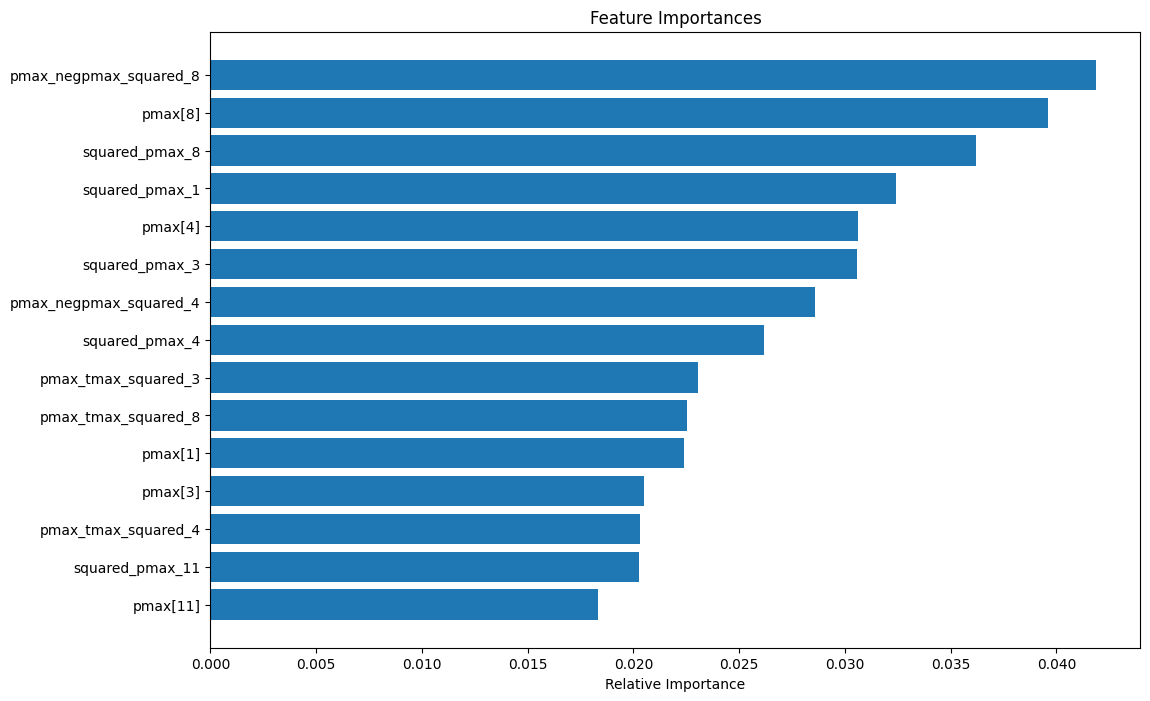

                    feature  importance
106  pmax_negpmax_squared_8    0.041885
30                  pmax[8]    0.039627
102          squared_pmax_8    0.036209
60           squared_pmax_1    0.032402
15                  pmax[4]    0.030610
74           squared_pmax_3    0.030569
85   pmax_negpmax_squared_4    0.028569
81           squared_pmax_4    0.026155
79      pmax_tmax_squared_3    0.023042
107     pmax_tmax_squared_8    0.022516
0                   pmax[1]    0.022413
10                  pmax[3]    0.020500
86      pmax_tmax_squared_4    0.020313
123         squared_pmax_11    0.020257
45                 pmax[11]    0.018306


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

importance = np.zeros(X.shape[1])

for estimator in model.estimators_:
    importance += estimator.feature_importances_

importance /= len(model.estimators_)
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

feature_contributions = 'feature_importances.csv'
feature_importances_sorted.to_csv(feature_contributions, index=False)
print(f"\nAll feature importances have been saved to {feature_contributions}")

top_15_feature_importances = feature_importances_sorted.head(15)
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(top_15_feature_importances['feature'], top_15_feature_importances['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Relative Importance')
plt.show()
print(top_15_feature_importances)


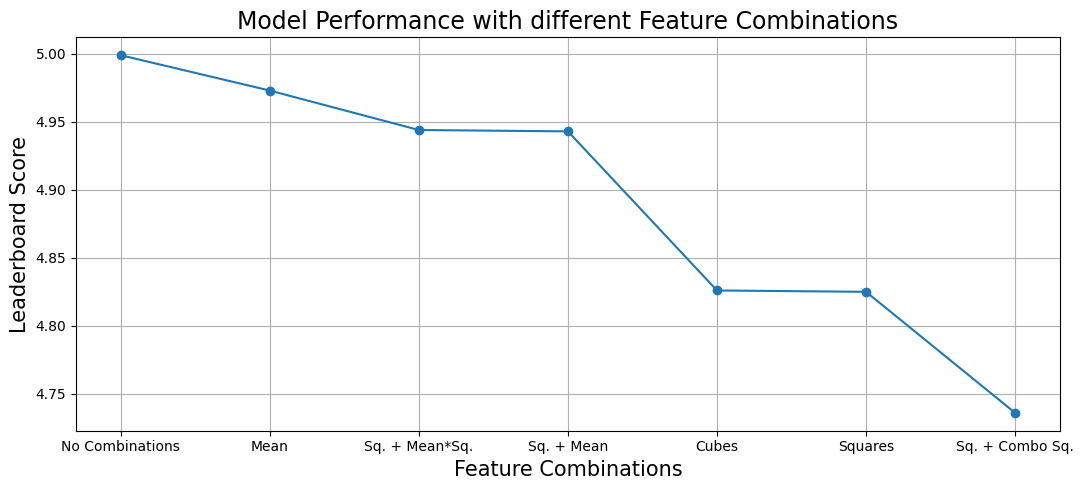

In [9]:
#Plot for generating Figure 1: "Comparison among different Feature Combinations"

import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Feature Combinations': ['No Combinations', 'Mean', 'Sq. + Mean*Sq.', 'Sq. + Mean' ,'Cubes', 'Squares', 'Sq. + Combo Sq.'],
    'Leaderboard Score': [4.999, 4.973, 4.944, 4.943, 4.826, 4.825, 4.736]  #Scores generated on the Leaderboard using the above feature Combinations
}

df = pd.DataFrame(data)

plt.figure(figsize=(11, 5))
plt.plot(df['Feature Combinations'], df['Leaderboard Score'], marker='o')
plt.title('Model Performance with different Feature Combinations', fontsize=17)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('X-axis Label', fontsize=15)
plt.ylabel('Y-axis Label', fontsize=15)
plt.xlabel('Feature Combinations')
plt.ylabel('Leaderboard Score')
plt.xticks(rotation=0, horizontalalignment='right', ha='center')
plt.grid(True)
plt.tight_layout() 
plt.savefig('feature_combinations.pdf', bbox_inches='tight')
plt.show()

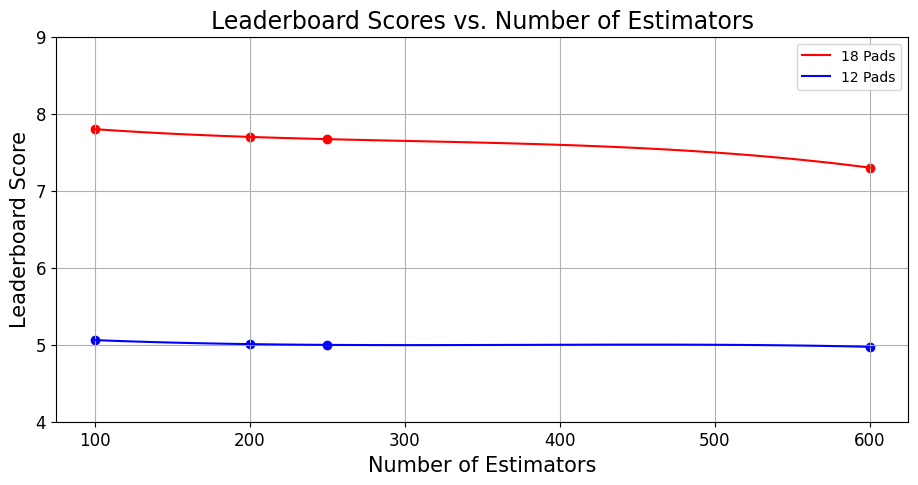

In [10]:
#Plot for generating Figure 2: "Impact of number of Estimators"

import matplotlib.pyplot as plt
import numpy as np

# With Noise dataset (18 Pads) - Hyperparameters(Depth = 50, Max_features = sqrt) & Feature Combinations(Mean) for the below readings were same for all 
score_18 = [7.8, 7.699, 7.67, 7.3] 
n_estimators_18 = [100, 200, 250, 600]

# Without Noise dataset (12 Pads) - Hyperparameters(Depth = 50, Max_features = sqrt) & Feature Combinations(Mean) for the below readings were same for all 
score_12 = [5.06, 5.008, 4.998, 4.973]
n_estimators_12 = [100, 200, 250, 600]


plt.figure(figsize=(11, 5))
curve_fit_18 = np.polyfit(n_estimators_18, score_18, 3)
curve_18 = np.poly1d(curve_fit_18)
estimators_18_smooth = np.linspace(min(n_estimators_18), max(n_estimators_18), 100)
score_18_smooth = curve_18(estimators_18_smooth)
curve_fit_12 = np.polyfit(n_estimators_12, score_12, 3)
curve_12 = np.poly1d(curve_fit_12)
estimators_12_smooth = np.linspace(min(n_estimators_12), max(n_estimators_12), 100)
score_12_smooth = curve_12(estimators_12_smooth)

plt.plot(estimators_18_smooth, score_18_smooth, label='18 Pads', color='red')
plt.plot(estimators_12_smooth, score_12_smooth, label='12 Pads', color='blue')
plt.scatter(n_estimators_18, score_18, color='red')
plt.scatter(n_estimators_12, score_12, color='blue')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Leaderboard Scores vs. Number of Estimators', fontsize=17)
plt.xlabel('X-axis Label', fontsize=15)
plt.ylabel('Y-axis Label', fontsize=15)
plt.xlabel('Number of Estimators')
plt.ylabel('Leaderboard Score')
plt.legend()
plt.grid(True)
plt.ylim(4, 9)

plt.savefig('n_estimators.pdf', bbox_inches='tight')
plt.show()